In [1]:
import torch
import time
import os
import cv2
import random 
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.backends.cudnn as cudnn
import torch.cuda.amp as amp 
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from focalnet import FocalNet
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from torchsummary import summary
from sklearn.metrics import roc_curve, auc

## Data Preprocessing & Augmentation
- **rgb_to_lab_and_clahe function** - Performs conversion of RGB image to LAB color space after blurring (Gaussian) the Green (G) AND Blue (B) channels to emphasize the R channel and performs CLAHE. 
- **Augmentation** - Transforms like random Horizontal flip, Vertical flip, Rotation, Gaussian Blur, Affine, Perspective projection & MixUp are applied to create diversity in the training dataset to enhance model training and improve generalization.  


In [2]:
def rgb_to_lab_and_clahe(img, clip_limit, tile_grid_size, blur_sigma):
    """
    Convert an RGB image to LAB color space, apply CLAHE (Contrast Limited Adaptive Histogram Equalization).

    Args:
        img (PIL.Image): Input RGB image.
        clip_limit (float): Clip limit for CLAHE.
        tile_grid_size (tuple): Size of the tile grid for CLAHE.
        blur_sigma (float): Standard deviation for Gaussian blur.

    Returns:
        lab_image (numpy.ndarray): LAB color space image.
    """        
    rgb_r, rgb_g, rgb_b = cv2.split(np.array(img))
    blurred_G = cv2.GaussianBlur(rgb_g, (5, 5), blur_sigma)
    blurred_B = cv2.GaussianBlur(rgb_b, (5, 5), blur_sigma)

    img = cv2.merge([rgb_r, blurred_G, blurred_B]) 
    lab_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2Lab)
    L, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahed_L = clahe.apply(L)  
    modified_lab_image = cv2.merge([clahed_L, a, b])
    rgb_image = cv2.cvtColor(modified_lab_image, cv2.COLOR_LAB2RGB)
    return lab_image 

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180), 
    transforms.GaussianBlur(kernel_size=5, sigma=(1.0, 3.0)),
    transforms.RandomAffine(degrees=0, translate=(0.25, 0.25), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    lambda x: rgb_to_lab_and_clahe(x, clip_limit=5.0, tile_grid_size=(8, 8), blur_sigma=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),   
])

val_transform = transforms.Compose([
    lambda x: rgb_to_lab_and_clahe(x, clip_limit=5.0, tile_grid_size=(8, 8), blur_sigma=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  
])

def mixup(data, targets, alpha=1.0):
    """
    Applies MixUp augmentation to the input data and targets.

    Args:
        data (torch.Tensor): Input data tensor.
        targets (torch.Tensor): Target labels tensor.
        alpha (float): MixUp hyperparameter controlling the mix ratio.

    Returns:
        mixed_data (torch.Tensor): Mixed data tensor.
        targets_a (torch.Tensor): Targets for the first data sample.
        targets_b (torch.Tensor): Targets for the second data sample.
        lam (float): Lambda value representing the mix ratio.
    """
    if alpha == 0:
        return data, targets, targets, 1.0 
    lam = np.random.beta(alpha, alpha)
    batch_size = data.size(0)
    index = torch.randperm(batch_size)
    mixed_data = lam * data + (1 - lam) * data[index, :]
    targets_a, targets_b = targets, targets[index]
    return mixed_data, targets_a, targets_b, lam

## Data Loading

In [3]:
# Set the device for PyTorch to CUDA if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set a random seed for reproducibility and configure CUDA for benchmarking.
seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

# Define the file paths for the training and validation datasets.
train_data_path = '/home/ee22s501/c2/data_classify/train'
val_data_path = '/home/ee22s501/c2/data_classify/val'

# Create PyTorch datasets with specified transformations.
train_dataset = ImageFolder(train_data_path, transform=train_transform)
val_dataset = ImageFolder(val_data_path, transform=val_transform)

# Set the batch size and create data loaders for training and validation.
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Model, Criterion & Optimizer

In [4]:
# Define the FocalNet Transformer model configuration.
FocalNet_config = {
    'img_size': 224,
    'patch_size': 4,
    'in_chans': 3,
    'num_classes': 2,
    'embed_dim': 96,
    'depths': [2,2,6,2],
    'window_size': [7,5,3,1],
    'mlp_ratio': 4,
    'stochastic_depth_prob': 0.1,
}

# Instantiate FocalNet Transformer model. 
model = FocalNet(img_size=FocalNet_config['img_size'],
                        patch_size=FocalNet_config['patch_size'],
                        in_chans=FocalNet_config['in_chans'],
                        num_classes=FocalNet_config['num_classes'],
                        embed_dim=FocalNet_config['embed_dim'],
                        depths=FocalNet_config['depths'],
                        focal_windows=FocalNet_config['window_size'],
                        mlp_ratio=FocalNet_config['mlp_ratio'],
                        drop_rate=0.,
                        drop_path_rate=0.1,
                        norm_layer=nn.LayerNorm, 
                        patch_norm=True,
                        use_checkpoint=False,                 
                        focal_levels=[1,1,1,1],
                        use_conv_embed=False, 
                        use_layerscale=False, 
                        layerscale_value=1e-4, 
                        use_postln=False, 
                        use_postln_in_modulation=False, 
                        normalize_modulator=False
                        ).to(device)

# Generate a summary of the model's architecture
# summary(model()) 

# Set up the Cross Entropy loss function
criterion = nn.CrossEntropyLoss()

# Set the Optimizer as AdamW
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=7.8125e-06,     
    betas=(0.9, 0.999), 
    eps=1.0e-08,      
    weight_decay=0.04,   
)

# Set the Scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=30,   
    eta_min=7.8125e-08  
)

# Set gradient scaler
scaler = amp.GradScaler()

## Training and Validation

############################################################
Epoch 1/100, Train Loss: 0.6999485755467233, Time: 11.52 seconds
############################################################
Epoch 2/100, Train Loss: 0.6847376479902341, Time: 10.66 seconds
Val Loss: 0.8796380619433793
Current Validation Accuracy: 50.0%
Current Validation Recall: 1.0
Current Validation F1 Score: 0.6666666666666666
Model Saved!
############################################################
Epoch 3/100, Train Loss: 0.684348818910031, Time: 10.69 seconds
############################################################
Epoch 4/100, Train Loss: 0.6493053794589662, Time: 10.78 seconds
Val Loss: 0.7908545494869803
Current Validation Accuracy: 59.732824427480914%
Current Validation Recall: 0.9885496183206107
Current Validation F1 Score: 0.710562414266118
Model Saved!
############################################################
Epoch 5/100, Train Loss: 0.6404833210106115, Time: 10.84 seconds
###############################

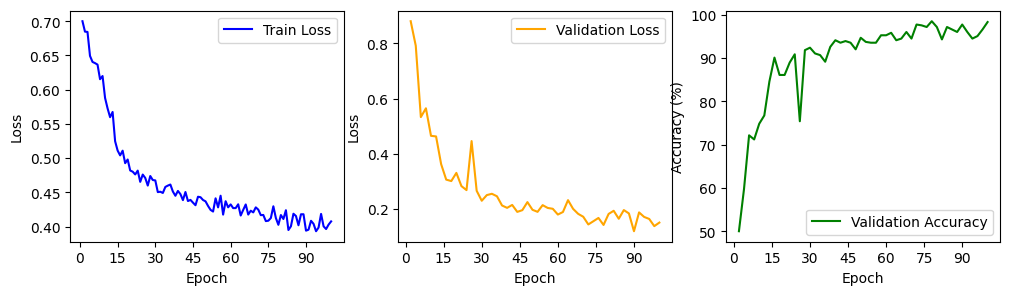

In [5]:
# Initialize training parameters and lists to track metrics.
num_epochs = 100
best_accuracy = 0.0
best_recall = 0.0
best_f1_score = 0.0
best_epoch_accuracy = 0
best_model_path = '/home/ee22s501/cvip/code/FocalNet_modelpath'
train_losses = []
val_losses = []
val_accuracies = []

# Main training loop over epochs.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    # Training loop over batches.
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Apply MixUp augmentation.
        if np.random.rand() < 0.5:
            images, targets_a, targets_b, lam = mixup(images, labels, alpha=1.0)
        else:
            images, targets_a, targets_b, lam = mixup(images, labels, alpha=1.0)
        optimizer.zero_grad()
        
        with amp.autocast():
            outputs = model(images)
            #loss = criterion(outputs, labels)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #scheduler.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss/len(train_loader))
    end_time = time.time()
    epoch_time = end_time - start_time
    print("############################################################")
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Time: {epoch_time:.2f} seconds")

    if (epoch + 1) % 2 == 0:
        model.eval()
        correct = 0
        total = 0
        val_predictions = []
        val_labels = []
        running_val_loss = 0.0

        # Validation loop to evaluate model performance.
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_loss = criterion(outputs, labels)   
                running_val_loss += val_loss.item()

        accuracy = 100 * correct / total
        val_losses.append(running_val_loss/len(val_loader))

        # Print and save model performance metrics.
        print(f"Val Loss: {running_val_loss/len(val_loader)}")
        val_accuracies.append(accuracy)
        recall = recall_score(val_labels, val_predictions)
        f1 = f1_score(val_labels, val_predictions)

        print(f"Current Validation Accuracy: {accuracy}%")
        print(f"Current Validation Recall: {recall}")
        print(f"Current Validation F1 Score: {f1}")

        # Save the model.
        model_path = os.path.join(best_model_path, f"model_classify_{epoch + 1}.pth")
        torch.save(model.state_dict(), model_path)
        print("Model Saved!")

# Plot training and validation metrics.
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1, 1), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(2, num_epochs + 1, 2), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(2, num_epochs + 1, 2), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()
plt.show()


## Preprocessing & Dataloader for Test Data

In [12]:
#Defining data preprocessing for test data.
test_transform = transforms.Compose([
    lambda x: rgb_to_lab_and_clahe(x, clip_limit=5.0, tile_grid_size=(8, 8), blur_sigma=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
])

#Defining path for saving test prediction, model checkpoint, CAMs, and Excel file
test_data_path = '/home/ee22s501/cvip/code/dummy'
model_path = '/home/ee22s501/cvip/code/FocalNet_modelpath/model_classify_78.pth'  
cams_path = '/home/ee22s501/cvip/code/FocalNet_result/cams'
excel_file_path = '/home/ee22s501/cvip/code/FocalNet_result/predictions_classify.xlsx'
batch_size = 1

# Create a test dataset and data loader for inference.
test_dataset = ImageFolder(test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Prediction and CAM plot generation

In [7]:
# Define a function to reshape a tensor for Ablation-CAM function 
def reshape_transform(tensor, height=7, width=7):
    """
    Reshape a tensor to the specified height and width dimensions.

    Args:
        tensor (torch.Tensor): Input tensor.
        height (int): Target height dimension.
        width (int): Target width dimension.

    Returns:
        result (torch.Tensor): Reshaped tensor.
    """
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result 


# Load a pre-trained model and set it to evaluation mode.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(model_path))
model.eval()

# Define class names, fonts, and variables for predictions and image file names.
class_names = ['bleeding', 'non_bleeding']
i = 0
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (255, 255, 255)
font_thickness = 1
predicted_labels = []
image_file_names = []
x=[]

# Loop through test data and generate predictions.
for images, _ in test_loader:
    images = images.to(device)
    outputs = model(images)
    #print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    x.append(predicted)
    
    predicted_label = class_names[predicted.item()]
    print(predicted_label)
# Uncomment this code for generating Ablation-CAM plots. 
    # target_layers = [model.layers[-1].blocks[-1].norm2]
    # cam = AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())
    # grayscale_cam = cam(input_tensor=images, aug_smooth=True, eigen_smooth=True, targets=None)
    # rgb_img = cv2.imread(test_loader.dataset.samples[i][0], 1)[:, :, ::-1]
    # rgb_img_n = np.float32(rgb_img) / 255
    # cam_image = show_cam_on_image(rgb_img_n, grayscale_cam[0, :])

    # predicted_labels.append(predicted_label)
    # image_file_names.append(os.path.basename(test_loader.dataset.samples[i][0]))

    # combined_image = np.copy(cam_image)
    # text = f'Predicted: {predicted_label}'
    # cv2.putText(combined_image, text, (15, 15), font, font_scale, font_color, font_thickness)
    # cv2.imwrite(os.path.join(cams_path, os.path.basename(test_loader.dataset.samples[i][0])), combined_image)

    ## Append predicted labels and image file names.
    # file_name = os.path.splitext(os.path.basename(test_loader.dataset.samples[i][0]))[0]
    # image_file_names.append(file_name)
    # predicted_labels.append(predicted.item())
    # i += 1

# Create a DataFrame and save predictions to an Excel file.
data = {
    'Image name': image_file_names,
    'Predicted Class label': predicted_labels,
}
df = pd.DataFrame(data)
df['Predicted Class label'] = df['Predicted Class label'].map({0: 'Bleeding', 1: 'Non-Bleeding'})

df.to_excel(excel_file_path, index=False)
print(f"Predictions saved to {excel_file_path}")


bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
non_bleeding
bleeding
non_bleeding
non_bleeding
bleeding
bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
non_bleeding
bleeding
non_bleeding
non_bleeding
bleeding
bleeding
bleeding
bleeding
bleeding
bl